## 50 Startups Profit prediction 

For this project we will be predicting profit for startups with respect to different features such as R&D Spend, Administration, Marketing Spend, States(in US)

### Import Required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Import CSV file

In [2]:
# Importing the dataset
dataset = pd.read_csv('c:/users/shekh/Desktop/GitProjects/50 Startup profit pred/50_Startups.csv')
dataset.tail()

,R&D Spend,Administration,Marketing Spend,State,Profit
45,1000.23,124153.04,1903.93,New York,64926.08
46,1315.46,115816.21,297114.46,Florida,49490.75
47,0.00,135426.92,0.00,California,42559.73
48,542.05,51743.15,0.00,New York,35673.41
49,0.00,116983.80,45173.06,California,14681.40


In [3]:
dataset.shape

(50, 5)

In [4]:
dataset = dataset.dropna()

In [5]:
dataset.shape

(50, 5)

In [6]:
#extracting numerical features
# list of numerical variables
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

## Check for Outliers

In [7]:
# define a funciton for boxplot

def plot_boxplot(df,ft):
    df.boxplot(column=[ft])
    plt.show()
    

In [8]:
numerical_features

['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']

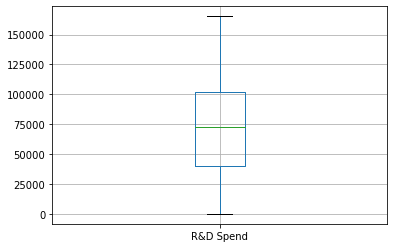

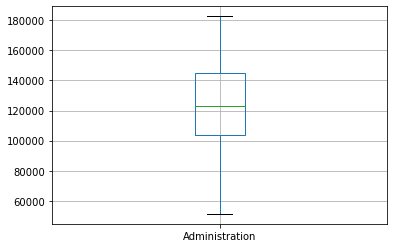

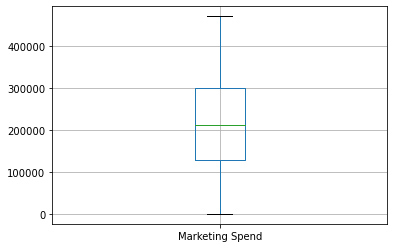

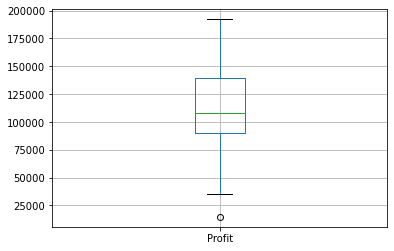

In [9]:
for feature in numerical_features:
    plot_boxplot(dataset,feature)

In [10]:
# define a function called 'outliers' which returns a list of index of outliers
# IQR = Q3-Q1

def outliers(df,ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    ls = df.index[ (df[ft] < lower_bound) | (df[ft] > upper_bound)]
    
    return ls

In [11]:
# create an empty list to store the output indices from the multiple columns

index_list = []
for feature in numerical_features:
    index_list.extend(outliers(dataset,feature))

In [12]:
index_list

[49]

In [13]:
# define a function called 'remove' which returns a cleaned dataframe without outliers

def remove(df,ls):
    ls =sorted(set(ls))
    df = df.drop(ls)
    return df

In [14]:
dataset = remove(dataset,index_list)

In [15]:
dataset.shape

(49, 5)

thus we can see that the outlier has been successfully removed form the dataset

.

we can see that we have some zero values we need to take care of them first

### We need to remove any numerical features row with 0 values as all the features needs to be addressed for successful prediction of profit for the startup, as the 3 variables are the basic investment required for a startup to get started. 

In [16]:
def zerovalues(df,ft):
    
    ls = df.index[ (df[ft] == 0.0)]
    
    return ls

In [17]:
index_list1 = []
for feature in numerical_features:
    index_list1.extend(zerovalues(dataset,feature))

In [18]:
index_list1

[47, 19, 47, 48]

In [19]:
# define a function called 'remove' which returns a cleaned dataframe without zerovalues

def remove1(df,ls):
    ls =sorted(set(ls))
    df = df.drop(ls)
    return df

In [20]:
dataset = remove1(dataset,index_list1)

In [21]:
dataset.shape

(46, 5)

### Lets see the pairplot for the dataset with help of seaborn 

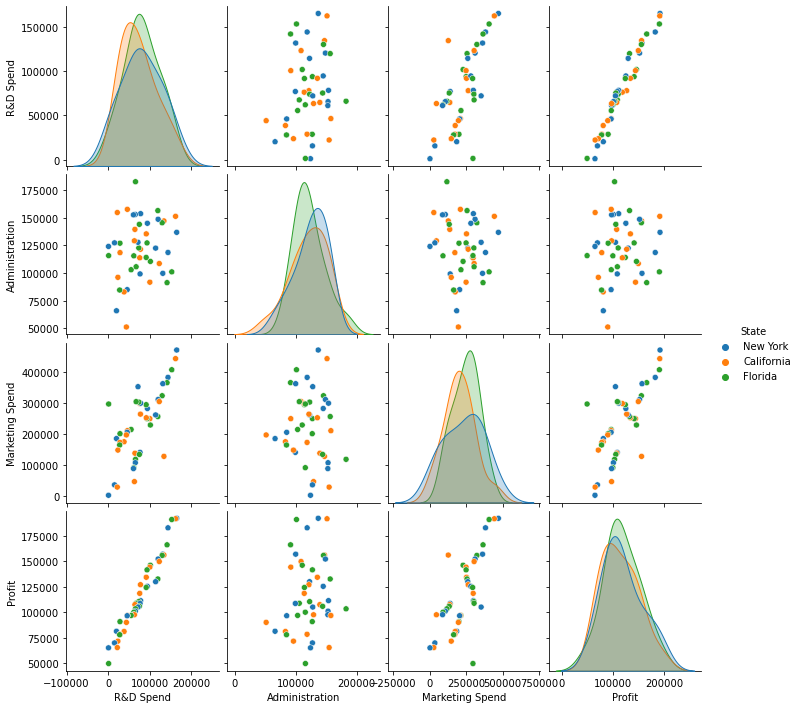

In [22]:
pairplot = sns.pairplot(dataset,hue='State')

we can see that the categorical variable has been automatically dropped for the plot 

from the plots we can see that our dependent vairable i.e. profit is linearly correlated to R&D Spend, and Marketing Spend, but with Admisnitration the plot is somewhat randomly scattered lets verify it with the correlation matrix

In [23]:
cor_matrix = dataset.corr()
cor_matrix

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000000,0.196068,0.708253,0.977703
Administration,0.196068,1.000000,-0.085831,0.135076
Marketing Spend,0.708253,-0.085831,1.000000,0.732277
Profit,0.977703,0.135076,0.732277,1.000000


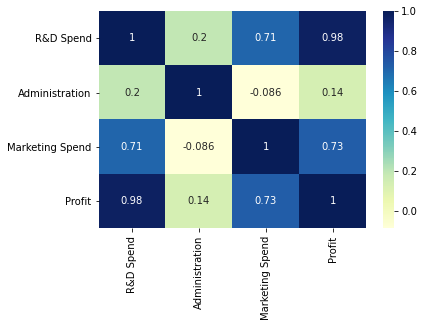

In [24]:
heatmap = sns.heatmap(cor_matrix, cmap="YlGnBu", annot=True)

independent features marketing spend and R&D spend are modelrately correlated, we will run the model with linear regression and also with Ridge and Lasso regression. and compare the models performance with metric 'Negative mean squared error' and r2_score

In [25]:
X = dataset.iloc[:,:-1] #independent features
y = dataset.iloc[:,-1] #dependent features

In [26]:
X.head(),y.head()

(   R&D Spend  Administration  Marketing Spend       State
 0  165349.20       136897.80        471784.10    New York
 1  162597.70       151377.59        443898.53  California
 2  153441.51       101145.55        407934.54     Florida
 3  144372.41       118671.85        383199.62    New York
 4  142107.34        91391.77        366168.42     Florida,
 0    192261.83
 1    191792.06
 2    191050.39
 3    182901.99
 4    166187.94
 Name: Profit, dtype: float64)

Now we can see that there is categorical independent feature so we need to perform one hot encoding to simplify it for the model as input

### Onehot Encoding Using Dummy Variable Trap

In [27]:
states = pd.get_dummies(X['State'], drop_first = True)

### Dropping State Column & Concatinating Dummy Variables

In [28]:
X = X.drop('State', axis = 1)

In [29]:
X = pd.concat([X,states], axis = 1)

In [30]:
X.head()

,R&D Spend,Administration,Marketing Spend,Florida,New York
0,165349.20,136897.80,471784.10,0,1
1,162597.70,151377.59,443898.53,0,0
2,153441.51,101145.55,407934.54,1,0
3,144372.41,118671.85,383199.62,0,1
4,142107.34,91391.77,366168.42,1,0


### splitting the dataset into training and testing set

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,random_state = 0)

## Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression
lin_regressor=LinearRegression()
mse=cross_val_score(lin_regressor,X,y,scoring='neg_mean_squared_error',cv=5)
mean_mse=np.mean(mse)
print(mean_mse)

-80224872.35371973


In [33]:
lin_regressor.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = lin_regressor.predict(X_test)
# round predictions
rounded_lr = [round(x,2) for x in y_pred]
print(rounded_lr)

[110337.55, 109245.33, 104399.38, 166479.02, 132987.52, 103076.86, 99944.96, 136287.08, 118402.72, 98227.14, 100636.04, 88458.29, 65907.65, 175709.56]


In [35]:
result = pd.DataFrame(data={'predictions': rounded_lr, 'actual': y_test})

In [36]:
result.head()

,predictions,actual
26,110337.55,105733.54
23,109245.33,108733.99
29,104399.38,101004.64
4,166479.02,166187.94
10,132987.52,146121.95


In [37]:
from sklearn.metrics import r2_score
score = r2_score(y_test,y_pred)
print(score)

0.9552067589694804


## Ridge Regression (Linear regression with L2 regularisation).

In [38]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error')

In [39]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 100}
-69878047.1788512


In [40]:
y_pred_rid = ridge_regressor.predict(X_test)
# round predictions
rounded_rid = [round(x,2) for x in y_pred_rid]
print(rounded_rid)

[111603.91, 111158.09, 103015.56, 171155.66, 136118.27, 101627.0, 102126.93, 136772.85, 116630.28, 100222.26, 99196.83, 87593.64, 64245.19, 180183.67]


In [41]:
result_rid = pd.DataFrame(data={"prediciton":rounded_rid, 'actual': y_test})

In [42]:
result_rid.head()

,prediciton,actual
26,111603.91,105733.54
23,111158.09,108733.99
29,103015.56,101004.64
4,171155.66,166187.94
10,136118.27,146121.95


In [43]:
from sklearn.metrics import r2_score
score_rid = r2_score(y_test,y_pred_rid)
print(score_rid)

0.9676929480385433


## Lasso Regression (Linear regression with L1 regularisation).

In [44]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(X,y)
print(lasso_regressor.best_params_)
print(round(lasso_regressor.best_score_,2))

{'alpha': 100}
-78315611.8


In [45]:
y_pred_lasso=lasso_regressor.predict(X_test)
# round predictions
rounded_lasso = [round(x,2) for x in y_pred_lasso]
print(rounded_lasso)


[111278.5, 110922.62, 102829.74, 170885.73, 135803.84, 101958.92, 101752.29, 137180.9, 116573.32, 99929.23, 99000.84, 87991.73, 64023.86, 179944.34]


In [46]:
result_lasso = pd.DataFrame(data={"prediciton":rounded_lasso, 'actual': y_test})

In [47]:
result_lasso.head()

,prediciton,actual
26,111278.50,105733.54
23,110922.62,108733.99
29,102829.74,101004.64
4,170885.73,166187.94
10,135803.84,146121.95


In [48]:
from sklearn.metrics import r2_score
score_lasso = r2_score(y_test,y_pred_lasso)
print(score_lasso)

0.9674448642930218


## Now lets see how lasso selected independent features

In [49]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [50]:
feature_sel_model = SelectFromModel(Lasso(alpha=0.100, random_state=0)) 
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.1, random_state=0))

In [51]:
feature_sel_model.get_support()

array([ True,  True,  True,  True,  True])

In [52]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feat = X_train.columns[(feature_sel_model.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(feature_sel_model.estimator_.coef_ == 0)))

total features: 5
selected features: 5
features with coefficients shrank to zero: 0


In [53]:
selected_feat

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'Florida',
       'New York'],
      dtype='object')

we can see that Lasso Regression selected all the feature

## Random Forest Regression

In [54]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 700, random_state = 0)
regressor.fit(X_train,y_train)

RandomForestRegressor(n_estimators=700, random_state=0)

In [55]:
y_pred_rf = regressor.predict(X_test)
# round predictions
rounded_rf = [round(x,2) for x in y_pred_rf]
print(rounded_rf)

[114653.08, 108159.01, 104419.23, 167903.14, 136344.11, 105568.15, 106200.83, 136348.16, 122375.27, 99266.31, 104879.77, 88812.54, 68487.2, 182421.04]


In [56]:
result_rf = pd.DataFrame(data={"prediciton":rounded_rf, 'actual': y_test})

In [57]:
result_rf.head()

,prediciton,actual
26,114653.08,105733.54
23,108159.01,108733.99
29,104419.23,101004.64
4,167903.14,166187.94
10,136344.11,146121.95


In [58]:
from sklearn.metrics import r2_score
score_rf = r2_score(y_test,y_pred_rf)
print(score_rf)

0.9545769788135249


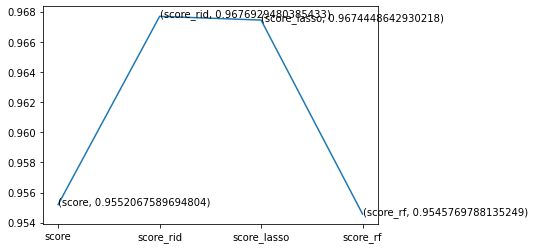

In [59]:
x = ['score','score_rid','score_lasso','score_rf']
ypoints = np.array([score,score_rid,score_lasso,score_rf])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x,ypoints)
for xy in zip(x, ypoints):                                      
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 
# plt.plot(x,ypoints, linestyle = 'dashed',color = 'r')

plt.show()

In [60]:
from sklearn.metrics import r2_score
score = r2_score(y_test,y_pred_rf)
print(score)

0.9545769788135249


In [61]:
list = [score,score_rid,score_lasso,score_rf]


if (score == max(list)):
    print('The best r2 score is {:.7f} for LinearRegression model.'.format(score))
elif (score_rid == max(list)):
    print('The best r2 score is {:.7f} for Ridge Regression model.'.format(score_rid))
elif (score_lasso == max(list)):
    print('The best r2 score is {:.7f} for Lasso Regression model.'.format(score_lasso))

else:
    print('The best r2 score is {:.7f} for Random Forest Regression mode.'.format(score_lasso))


The best r2 score is 0.9676929 for Ridge Regression model.
